In [1]:
%load_ext autoreload
%autoreload 2

from calc_del_lambda import import_lab_frame_spectra
lab = import_lab_frame_spectra('/home/agoga/Documents/nreshk/data/LabSpectra/', resolution=0)#,res*10)

In [2]:
#BEFORE RUNING THIS MAKE SURE CALC_DEL_LAMBDA HAS A LOCAL WIDTH OF AROUND 50

import scipy as sc
from scipy import interpolate

import astropy.io.fits
import numpy as np
import os

from calc_shk import calc_targOlapf
from calc_shk import calc_shk
from calc_shk import smart_calc_shk


from calc_del_lambda import tmp_find_del_lam
from calc_del_lambda import lamda_zoom
from calc_del_lambda import pdf_from_data
from helpers import mkdir_p
from helpers import bad_spec_detection

from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt

from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages


def print_header(hdu):
    for i in hdu[0].header:
        print(i + ': ' + str(hdu[0].header[i]))
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey
def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)


dataPath ='/home/agoga/Documents/nreshk/data/smarts/'
padWidth= 1000
hduList = []
data = [[],[]]
for root, dirs, files in os.walk(dataPath):
    dirs[:] = [d for d in dirs if d not in exclude]
    
    for file in files:
        if file.endswith(".fits"):
            hdu = astropy.io.fits.open(os.path.join(root, file))
            
            #print_header(hdu)
            hduList.append(hdu)
            spec = hdu[0].data[0][0]
            
            lamStep = hdu[0].header['CD1_1']#lamda grid step value
            lamStart = hdu[0].header['CRVAL1'] #labda grid start value

            lamGrid = lamStart + np.arange(len(spec))*lamStep
            
            
            #RICKY HACK
            #we want the lamda grid to be rougly 10 times longer in the same range
            hackedValue = 10
            adjLamGrid = lamStart + np.arange(len(spec)*hackedValue)*lamStep/10#/10 bc angstroms
            #print(lamGrid)
            #print(adjLamGrid)
            interpfunc = interpolate.interp1d(lamGrid, spec, kind='linear',fill_value='extrapolate')
            
            adjSpec=interpfunc(adjLamGrid)
            #E HACK
            
            #removed padding as it does not affect TODO TEST once proper correlation working
            #lamda grid padding 
            #backPad = lamGrid[-1] + np.arange(padWidth)*lamStep
            #frontPad = np.flip(lamGrid[0] - np.arange(padWidth)*lamStep)
            
            #lamGrid = np.append(np.append(frontPad,lamGrid),backPad)
            
            #need to pad the edges with 0's
            #spec = np.pad(spec,pad_width=padWidth,mode='constant',constant_values=0)
            #end padding
            
            #both grids are in angstroms but that's ugly
            lamGrid = lamGrid/10
            labGrid=lab[0]/10
            
            print(lamGrid[1]-lamGrid[0])
            
            
            #plt.figure(figsize=(20,6))
            #plt.plot(lamGrid,spec,'g-')
            #plt.show()
            #plt.close()
            
            
            
            #gausLab = sc.ndimage.filters.gaussian_filter(labSpc,.1/dLam)
            out = tmp_find_del_lam(labGrid,lab[1],lamGrid, spec,1)
           # print(out)
            dLam = out[0]
            labSpec = out[2]

            #RICKY HACK
            #this is because our 
           # dLam = dLam
            #E
            
            
            #plt.figure(figsize=(20,6))
           # plt.plot(lamGrid,out[2]*1000,'b-')
            #plt.plot(lamGrid,spec,'g-')
            ##plt.show()
            #plt.close()
            
            print('lamd adj: ' + str(dLam))
            #shkRet = calc_shk(lamGrid-dLam, spec, 0, teff=6200)
            shkRet = smart_calc_shk(lamGrid-dLam, spec, 0, teff=6200)
            #shkRet = calc_shk(adjLamGrid/10-dLam, adjSpec, 0, teff=6200)
            shk = shkRet[0]
            windows = shkRet[1]
            
            
            
            
            #HELL TIME CONVERSION
            import time
            from astropy.time import Time
            fileDate = hdu[0].header['WAVEFILE'][4:]
            date = time.strptime(fileDate, "%a %b %d %H:%M:%S %Y")
            iso = time.strftime('%Y-%m-%dT%H:%M:%SZ', date)
            
            t= Time(iso, format='isot')
            t.format = 'decimalyear'
            ##E
            label = str(t.value)
            print("shk: " + str(shk) + " for obs: "+label)
            mkdir_p("output/"+"SMARTS/")
            #pdf_from_data(lamGrid, labSpec,lamGrid-dLam, spec, spec,windows, "output/"+"SMARTS/",label,.3)
            
            data[0].append(t.value)
            data[1].append(shk)

0.0564154714062397
lamd adj: 0.03129481090164064
shk: 0.24113633821720165 for obs: 2008.1227304062943
0.0564154714062397
lamd adj: 0.015234685850777144
shk: 0.24504805623932763 for obs: 2008.1227304062943
0.056259440229268876
lamd adj: -0.006296093239709815
shk: 0.23783256967825228 for obs: 2008.2051531193079
0.056259440229268876
lamd adj: -0.00038005491124649607
shk: 0.2411640272275588 for obs: 2008.2051531193079
0.05621927234187751
lamd adj: -0.00928833037672286
shk: 0.2456976332796045 for obs: 2008.5191245446265
0.05621927234187751
lamd adj: -0.009449544578705537
shk: 0.24677513843750437 for obs: 2008.5191245446265
0.05624436568501778
lamd adj: -0.015546924035015607
shk: 0.24339490040353845 for obs: 2008.5618878390003
0.05624436568501778
lamd adj: -0.01597412248871445
shk: 0.24942141181464197 for obs: 2008.5618878390003
0.056252326231515326
lamd adj: -0.014652419958094104
shk: 0.23300867915236453 for obs: 2008.568637295082
0.056252326231515326
lamd adj: -0.015077235734502283
shk: 0.

lamd adj: -0.0024434783889798347
shk: 0.2426541485314672 for obs: 2010.719688419584
0.05620696212503162
lamd adj: 0.0005506912332570483
shk: 0.24801272319778833 for obs: 2010.719688419584
0.05620310230790437
lamd adj: 0.005410244956116017
shk: 0.2340125873106472 for obs: 2010.7862695015222
0.05620297953322506
lamd adj: 0.0054219090674119345
shk: 0.24373165389478182 for obs: 2010.7862695015222
0.056205240914266597
lamd adj: 0.003987382945021255
shk: 0.253050762259007 for obs: 2010.799231576611
0.05620397185248294
lamd adj: 0.0004050347946232888
shk: 0.2506850239144025 for obs: 2010.799231576611
0.05620749299447425
lamd adj: 0.010801683373765568
shk: 0.24621426275102193 for obs: 2010.854472380771
0.056203250066744204
lamd adj: 0.00881845389429605
shk: 0.2529964712297451 for obs: 2010.854472380771
0.05620463041640278
lamd adj: 0.01080041327448097
shk: 0.2512389217982275 for obs: 2010.9006743404364
0.056205614077612154
lamd adj: 0.011769880532111934
shk: 0.25952437805437684 for obs: 2010.9

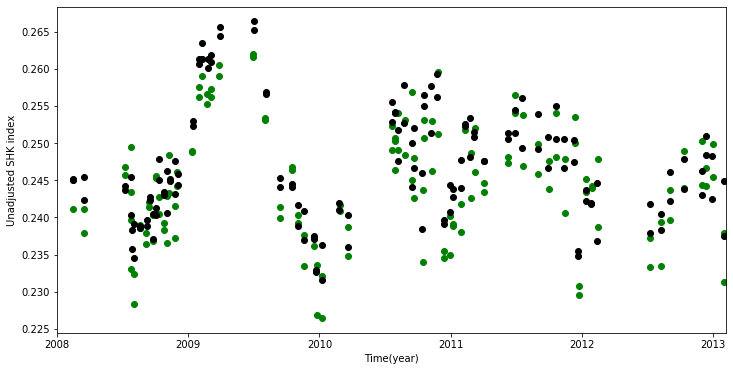

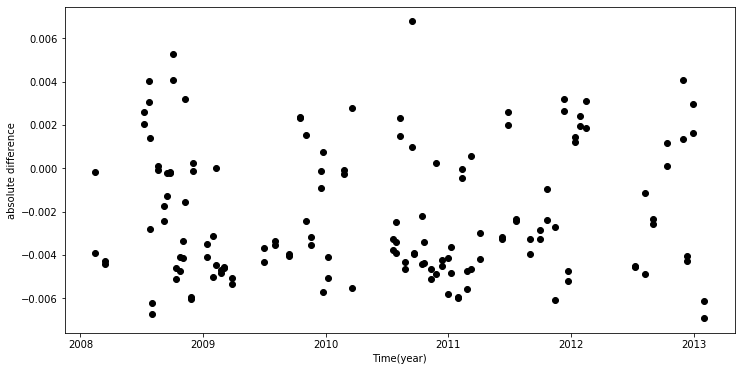

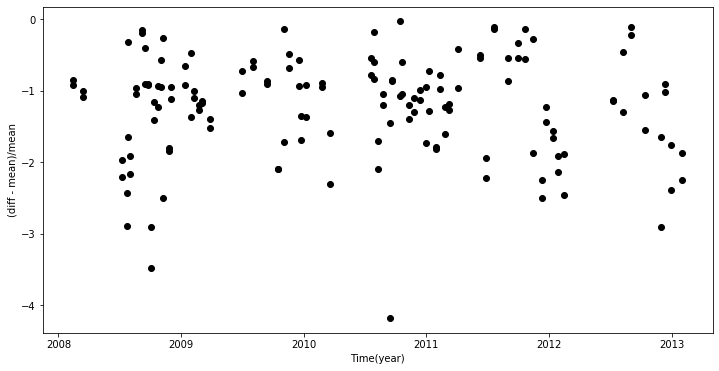

mean: -0.0021295454591322227
[ -84.8122925   -91.50317454 -108.65627933 -100.69882773 -196.52920396
 -220.83040662 -242.60791619 -289.02680839  -31.26373216 -165.20773323
 -191.31710363 -216.98986175 -103.79327028  -96.38580314  -14.30198072
  -18.8745999   -89.75651772  -40.23944549  -90.4390689   -92.42438616
 -347.59231165 -290.87044692 -140.37686569 -115.54250996  -92.60066733
 -122.00320953  -95.25346258  -56.87343821 -249.76524068  -25.70795294
 -183.91931703 -179.79063627 -111.4105839   -94.18928986  -91.91058266
  -64.74312888 -136.24248694  -46.94895456 -110.52118821 -100.494306
 -119.86240471 -126.28343557 -116.81055209 -114.30847726 -139.08945278
 -151.57393087  -72.08774282 -103.23322723  -66.28825881  -58.54985105
  -85.69291164  -90.91840112 -208.90483187 -210.14167276 -171.81113296
  -13.69274823  -48.15016303  -67.27122063  -56.07694109  -93.62626922
 -168.34803506 -135.37664127  -92.10270572 -137.29159348  -95.16356354
  -88.33985196 -159.46382005 -230.37004255  -53.51

In [4]:
shkArray = np.asarray(data)

realFile = open(dataPath+"HD17051.txt", "r")
realData = realFile.readlines()

perfData = [[],[]]
for x in realData:
    cDate = x.split(' ')[0]
    cShk = x.split(' ')[1]
    #print(cDate + ' : ' + cShk)
    perfData[0].append(float(cDate))
    perfData[1].append(float(cShk))
realFile.close()

#siteArray = np.asarray(sites)
plt.figure(figsize=(12,6))    
#t= Time(shkArray[0], format='mjd')
#t.format = 'decimalyear'
plt.xlim([2008,2013.1])
#plt.ylim([.18,.45])
#print(perfData[0])
plt.plot(shkArray[0],shkArray[1], 'go')
plt.plot(perfData[0],perfData[1], 'ko')

#plt.title('HD '+setName+' magnetic activity cycle')
plt.xlabel('Time(year)')
plt.ylabel('Unadjusted SHK index')
plt.savefig('output/SmartsSHKs.pdf')
#plt.savefig('output/'+setName+'shk_time_series.pdf')
plt.show()
plt.close()


diffArr = (shkArray[1]-perfData[1])
tArr  = shkArray[0][abs(diffArr)< .7] 
diffArr = diffArr[abs(diffArr)< .7]
mean = np.mean(diffArr)


plt.figure(figsize=(12,6))  
plt.plot(tArr,diffArr,'ko')
plt.xlabel('Time(year)')
plt.ylabel('absolute difference')
plt.savefig('output/SmartsDifferences.pdf')
plt.show()
plt.close()

plt.figure(figsize=(12,6))  
plt.plot(tArr,abs(diffArr-mean)/mean,'ko')
plt.xlabel('Time(year)')
plt.ylabel('(diff - mean)/mean')
plt.savefig('output/SmartsDivision.pdf')
plt.show()
plt.close()

print('mean: '+str(mean))
print(abs(diffArr-mean)/mean*100)